imports

In [4]:
import tensorflow as tf
#import tensorflow_datasets as tfds
from keras.applications import MobileNetV3Small
import matplotlib.pyplot as plt
import numpy as np


2024-10-24 15:47:02.873095: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Helper and preprocessing functions

In [5]:
def tf_scale_imgs(imgs, scale_factor):
    return imgs * scale_factor + 0.5 * (1 - scale_factor) * tf.ones(imgs.shape)


def tf_scale_labels(labels, scale_factor):
    return labels * scale_factor + 0.5 * (1 - scale_factor) * tf.ones(labels.shape)


def tf_f_inv(x, act_fn):
    """ (activation_size, batch_size) """
    if act_fn == "LINEAR":
        m = x
    elif act_fn == "TANH":
        num = tf.ones_like(x) + x
        div = tf.ones_like(x) - x + 1e-7
        m = 0.5 * tf.math.log(num / div)
    elif act_fn == "LOGSIG":
        div = tf.ones_like(x) - x + 1e-7
        m = tf.math.log((x / div) + 1e-7)
    else:
        raise ValueError(f"{act_fn} not supported")
    return m


def boring_movie(x, y, n_steps=4):
  """Stacks a Tensor to create a 'time series' of repeating images."""
  x = tf.stack([x for _ in range(n_steps)], axis=1)  # make the "boring" movie of subsequently following images
  y = tf.stack([y for _ in range(n_steps)], axis=1)
  return x, y


def random_omissions(x, y, omissions=0.5):
  """Randomly omits a fraction of the images in a batch.""" # why needed? -> not needed here 
  mask = tf.random.uniform(tf.shape(x)[:2], 0, 1)[:, :, None, None, None] > omissions
  x = x * tf.cast(mask, dtype=tf.float32)
  return x, y


def img_preproc(x, y, dtype=tf.float32): # add: tf.image.resize(image, [28,28])
  """Cast input image to a certain tf dtype and normalize them between 0 and 1."""
  x = tf.cast(x, dtype) / 255.
  #x = tf_scale_imgs(x, cf.img_scale)
  #y = tf_scale_labels(y, cf.label_scale)
  #x = tf_f_inv(x, "TANH")
  #y = tf.one_hot(y, depth=10)
  return x, y


def flatten(x, y):
  #flattens a video image series (or batch of images) to (n_batch, n_steps, 1) d.
  shape = tf.shape(x)
  if len(shape) == 5: # hack, determining if it's a video or not
    x = tf.reshape(x, [shape[0], shape[1], -1])
  elif len(shape) == 4:
    x = tf.reshape(x, [shape[0], -1])
  return x, y

def augment_images(batch_images, batch_labels):
    """
    Applies data augmentation on a batch of images without TensorFlow Addons.
    
    Parameters:
    batch_images: Tensor of shape (n_batch, 96, 96, 3)
    
    Returns:
    Augmented batch of images.
    """
    # Random horizontal flip
    augmented_images = tf.image.random_flip_left_right(batch_images)
    
    # Random brightness adjustment
    augmented_images = tf.image.random_brightness(augmented_images, max_delta=0.1)
    
    # Random contrast adjustment
    augmented_images = tf.image.random_contrast(augmented_images, lower=0.9, upper=1.1)
    
    # Random saturation adjustment
    augmented_images = tf.image.random_saturation(augmented_images, lower=0.9, upper=1.1)
    
    # Random hue adjustment
    augmented_images = tf.image.random_hue(augmented_images, max_delta=0.05)
    
    # Clipping to ensure pixel values are valid after transformations
    augmented_images = tf.clip_by_value(augmented_images, 0.0, 1.0)
    
    return augmented_images, batch_labels

resultspath = '/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_reduced_{epoch:02d}_{accuracy:.2f}.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= resultspath,  
    monitor='accuracy',         # The metric to monitor for saving (e.g., 'val_loss', 'val_accuracy')
    save_best_only=True,        # Save only the best model 
    save_weights_only=False,    # False = Save the entire model; True = only save weights
    mode='max',                 # Set to 'min' for metrics like loss and 'max' for metrics like accuracy
    save_freq='epoch',          # Frequency of saving, e.g., epoch or batch 
    verbose=1                   # Print when saving a model
)



In [26]:
class MobileNetPreproc:
    def __init__(self):
        # Initialize the MobileNetV3Small model with pretrained ImageNet weights
        # and exclude the top classification layer
        self.model = MobileNetV3Small(weights='imagenet', include_top=True, input_shape=(96, 96, 3))

    def __call__(self, x, y):
        # Preprocess x using the MobileNet model
        # The model transforms the input x and returns the encoded features
        return self.model(x), y  # Return the processed data and label unchanged
    
encoder_preproc = MobileNetPreproc()


/Users/denisekittelmann/miniconda3/envs/BiMo_3.9/lib/python3.9/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Load the data

In [7]:
# Create a leading and trailing dataset with tensorflow

img_dir_lead = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Leading/'
img_dir_trail = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Trailing/'
img_dir_test_lead = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Test/Test_Leading/'
img_dir_test_trail = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Test/Test_Trailing/'
class_names_L = ['barn', 'beach', 'cave', 'library', 'restaurant']
class_names_T = ['castle', 'Church', 'conference_room', 'forest'] # changed the order 
batch_size = None # adjust if needed, e.g., 32
image_size = (28,28)
validation_split = 0.1
seed = 123

In [ ]:
# Create a leading and trailing dataset with tensorflow

img_dir_lead = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Leading/'
img_dir_trail = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Trailing/' 
img_dir_test_lead = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Test/Test_Leading/' 
img_dir_test_trail = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Test/Test_Trailing/' 
class_names_L = ['barn', 'beach', 'cave', 'library', 'restaurant']
class_names_T = ['castle', 'Church', 'conference_room', 'forest'] # changed the order 
batch_size = 32
image_size = (28,28)
validation_split = 0.1
seed = 123

In [19]:
# Create a dict that assigns the correct labels for each leading-trailing img pair

"""
L1 = barn = label 0 
L2 = beach = label 1
L3 = library = label 3
L4 = restaurant = label 4 
L5 = cave = label 2

T6 = Church = label 1   
T7 = conference room = label 2
T8 = castle = label 0   
T9 = forest = label 3

MAPPING:

L1 -> T6 = 0.75 -> (0,1) 
L1 -> T7 = 0.25 -> (0,2)
L1 -> T8 = 0 -> (0,0)
L1 -> T9 = 0 -> (0,3)

L2 -> T6 = 0.75 -> (1,1) 
L2 -> T7 = 0.25 -> (1,2)
L2 -> T8 = 0 -> (1,0)
L2 -> T9 = 0 -> (1,3)

L3 -> T6 = 0 -> (3,1) 
L3 -> T7 = 0 -> (3,2)
L3 -> T8 = 0.5 -> (3,0)
L3 -> T9 = 0.5 -> (3,3)

L4 -> T6 = 0.25 -> (4,1) 
L4 -> T7 = 0.75 -> (4,2)
L4 -> T8 = 0 -> (4,0)
L4 -> T9 = 0 -> (4,3)

L5 -> T6 = 0.25 -> (2,1) 
L5 -> T7 = 0.75 -> (2,2)
L5 -> T8 = 0 -> (2,0)
L5 -> T9 = 0 -> (2,3)

"""

label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.0,
    (0, 0): 0.25,
    (0, 3): 0.75,
    (1, 1): 0.0,
    (1, 2): 0.0,
    (1, 0): 0.25,
    (1, 3): 0.75,
    (3, 1): 0.0,
    (3, 2): 0.0,
    (3, 0): 0.25,
    (3, 3): 0.75,
    (4, 1): 0.0,
    (4, 2): 0.0,
    (4, 0): 0.25,
    (4, 3): 0.75,
    (2, 1): 0.0,
    (2, 2): 0.0,
    (2, 0): 0.5,
    (2, 3): 0.5
}

label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.0,
    (0, 0): 1.,
    (0, 3): 1.,
    (1, 1): 0.0,
    (1, 2): 0.0,
    (1, 0): 1.,
    (1, 3): 1.,
    (3, 1): 0.0,
    (3, 2): 0.0,
    (3, 0): 1.,
    (3, 3): 1.,
    (4, 1): 0.0,
    (4, 2): 0.0,
    (4, 0): 1.,
    (4, 3): 1.,
    (2, 1): 0.0,
    (2, 2): 0.0,
    (2, 0): 1.,
    (2, 3): 1.
}

label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.75,
    (0, 0): 0.25,
    (0, 3): 0.25,
    
    (1, 1): 0.0,
    (1, 2): 0.75,
    (1, 0): 0.25,
    (1, 3): 0.25,
    
    (3, 1): 0.25,
    (3, 2): 0.25,
    (3, 0): 0.50,
    (3, 3): 0.50,
    
    (4, 1): 0.75,
    (4, 2): 0.0,
    (4, 0): 0.25,
    (4, 3): 0.25,
    
    (2, 1): 0.75, 
    (2, 2): 0.0,
    (2, 0): 0.25,
    (2, 3): 0.25
}

label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.0,
    (0, 0): 1.,
    (0, 3): 1.,
    (1, 1): 0.0,
    (1, 2): 0.0,
    (1, 0): 1.,
    (1, 3): 1.,
    (3, 1): 0.0,
    (3, 2): 0.0,
    (3, 0): 1.,
    (3, 3): 1.,
    (4, 1): 0.0,
    (4, 2): 0.0,
    (4, 0): 1.,
    (4, 3): 1.,
    (2, 1): 0.0,
    (2, 2): 0.0,
    (2, 0): 1.,
    (2, 3): 1.
}
    

label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.75,
    (0, 0): 0.25,
    (0, 3): 0.25,
    
    (1, 1): 0.0,
    (1, 2): 0.75,
    (1, 0): 0.25,
    (1, 3): 0.25,
    
    (3, 1): 0.75,
    (3, 2): 0.75,
    (3, 0): 0.50,
    (3, 3): 0.50,
    
    (4, 1): 0.75,
    (4, 2): 0.0,
    (4, 0): 0.25,
    (4, 3): 0.25,
    
    (2, 1): 0.75, 
    (2, 2): 0.0,
    (2, 0): 0.25,
    (2, 3): 0.25
}

label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.0,
    (0, 0): 1.,
    (0, 3): 1.,
    (1, 1): 0.0,
    (1, 2): 0.0,
    (1, 0): 1.,
    (1, 3): 1.,
    (3, 1): 0.0,
    (3, 2): 0.0,
    (3, 0): 1.,
    (3, 3): 1.,
    (4, 1): 0.0,
    (4, 2): 0.0,
    (4, 0): 1.,
    (4, 3): 1.,
    (2, 1): 0.0,
    (2, 2): 0.0,
    (2, 0): 1.,
    (2, 3): 1.
}

label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.75,
    (0, 0): 0.25,
    (0, 3): 0.25,
    
    (1, 1): 0.0,
    (1, 2): 0.75,
    (1, 0): 0.25,
    (1, 3): 0.25,
    
    (3, 1): 0.75,
    (3, 2): 0.75,
    (3, 0): 0.50,
    (3, 3): 0.50,
    
    (4, 1): 0.75,
    (4, 2): 0.0,
    (4, 0): 0.25,
    (4, 3): 0.25,
    
    (2, 1): 0.75, 
    (2, 2): 0.0,
    (2, 0): 0.25,
    (2, 3): 0.25
}

label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.0,
    (0, 0): 1.,
    (0, 3): 1.,
    (1, 1): 0.0,
    (1, 2): 0.0,
    (1, 0): 1.,
    (1, 3): 1.,
    (3, 1): 0.0,
    (3, 2): 0.0,
    (3, 0): 1.,
    (3, 3): 1.,
    (4, 1): 0.0,
    (4, 2): 0.0,
    (4, 0): 1.,
    (4, 3): 1.,
    (2, 1): 0.0,
    (2, 2): 0.0,
    (2, 0): 1.,
    (2, 3): 1.
}



label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.0,
    (0, 0): 1.,
    (0, 3): 1.,
    (1, 1): 0.0,
    (1, 2): 0.0,
    (1, 0): 1.,
    (1, 3): 1.,
    (3, 1): 0.0,
    (3, 2): 0.0,
    (3, 0): 1.,
    (3, 3): 1.,
    (4, 1): 0.0,
    (4, 2): 0.0,
    (4, 0): 1.,
    (4, 3): 1.,
    (2, 1): 0.0,
    (2, 2): 0.0,
    (2, 0): 1.,
    (2, 3): 1.
}

label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.75,
    (0, 0): 0.25,
    (0, 3): 0.25,
    
    (1, 1): 0.0,
    (1, 2): 0.75,
    (1, 0): 0.25,
    (1, 3): 0.25,
    
    (3, 1): 0.75,
    (3, 2): 0.75,
    (3, 0): 0.50,
    (3, 3): 0.50,
    
    (4, 1): 0.75,
    (4, 2): 0.0,
    (4, 0): 0.25,
    (4, 3): 0.25,
    
    (2, 1): 0.75, 
    (2, 2): 0.0,
    (2, 0): 0.25,
    (2, 3): 0.25
}

# alternative img sequence function 
def img_sequence2(img_t1, img_t2, label_t1, label_t2, label_dict): 
    """This function prepares an image pair and assigns a single label based on the label dictionary."""
    
    
    img_t1 = tf.cast(img_t1, dtype=tf.float32)
    img_t2 = tf.cast(img_t2, dtype=tf.float32)
    
    
    x = tf.concat([img_t1, img_t2], axis=0) 
    #print("Shape of x after stacking:", x.shape)

    
    key_t1 = int(label_t1.numpy())
    key_t2 = int(label_t2.numpy())
    #print("Current label pair:", (key_t1, key_t2)) 
    
    if (key_t1, key_t2) in label_dict:
        label = label_dict[(key_t1, key_t2)]
        #print(f"Label value found: {label}")
    else:
        print(f"Label pair {(key_t1, key_t2)} not found.")

    
    y = tf.cast(tf.random.uniform([]) < label, tf.float32)
    #y = tf.convert_to_tensor(label, dtype=tf.float32)
    y = tf.expand_dims(y, axis=0)  
    
    
    '''    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Two subplots for img_t1 and img_t2
    axes[0].imshow(img_t1.numpy().astype('uint8'))  # Convert image to uint8 for display
    axes[0].set_title(f"Image 1 (Label: {label})")
    axes[0].axis('off')  # Turn off axis for better display
    
    axes[1].imshow(img_t2.numpy().astype('uint8'))  # Convert image to uint8 for display
    axes[1].set_title(f"Image 2 (Label: {label})")
    axes[1].axis('off')  # Turn off axis for better display
    28
    plt.show()  # Display the images '''    


    #print("Generated label (y):", y.numpy())
    #print("Shape of y:", y.shape)

    #return x[x.shape[0]//2:,:], y
    return x,y


In [20]:
def generate_dataset(img_dirt1, img_dirt2, class_namest1, class_namest2, label_dict, image_size = None, seed = None, shuffle=False):       
    
    
    data_t1 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt1, 
        label_mode = 'int',
        class_names= class_namest1,
        batch_size = None,
        color_mode = 'rgb',
        image_size = image_size, 
        #shuffle = True, 
        seed = seed
        )

    data_t2 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt2, 
        label_mode = 'int',
        class_names= class_namest2,
        batch_size = None,
        color_mode = 'rgb', 
        image_size = image_size, 
        #shuffle = True, 
        seed = seed
    )
    
    if shuffle:
        data_t1.shuffle(99999)
        data_t2.shuffle(99999)
    
    # iterate through shuffled leading and trailing datasets
    leading = iter(data_t1)
    trailing = iter(data_t2) 
              
    while True:
        try:
            # Retrieve single samples
            img_t1, label_t1 = next(leading)
            img_t2, label_t2 = next(trailing)
            #print("test img shapes.", img_t1.shape, img_t2.shape)
            #print("Shape of label_t1:", label_t1.shape)
            #print("Shape of label_t2:", label_t2.shape)

            # Generate x, y pairs for single samples
            x, y = img_sequence2(img_t1, img_t2, label_t1, label_t2, label_dict)
            #print("test x:", x.shape)
            #print("test y:", y.shape) 
            yield x, y
            
        except StopIteration:
            # Break the loop if no more samples
            break

     

In [12]:
from collections import Counter

def check_transition_balance(dataset):
    transition_counts = Counter()
    
    # Use as_numpy_iterator to extract data from the dataset
    for image, label in dataset.as_numpy_iterator():
        # Convert label to a scalar value if it's in a numpy array form
        transition_counts[label[0]] += 1  # Assuming label is a scalar or one-element array
    
    print("Transition frequencies:")
    for transition, count in transition_counts.items():
        print(f"Transition {transition}: {count} occurrences")


In [21]:
# Build val_dataset 
seed = 123
#batch_size = 32
val_dataset = tf.data.Dataset.from_generator(
    lambda: generate_dataset(img_dir_test_lead, img_dir_test_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = seed),
    output_signature=(
        tf.TensorSpec(shape=(56, 28, 3), dtype=tf.float32),  # shape of x 2352; skip batch_size -> dataset.batch()
        tf.TensorSpec(shape=(1), dtype=tf.float32)  # shape of y 
    )
) 

print(val_dataset)
#check_transition_balance(val_dataset)

<_FlatMapDataset element_spec=(TensorSpec(shape=(56, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>


train the network

In [22]:
# define the model
model = tf.keras.models.Sequential([
    #tf.keras.layers.Dense(units=32, activation="tanh", input_shape=(1000,)),  # First layer + input layer
    tf.keras.layers.Dense(units=4, activation="sigmoid"),
    tf.keras.layers.Dense(units=2, activation="sigmoid"),  # Second layer
    tf.keras.layers.Dense(units=1, activation="sigmoid")  # Output layer
])

model.build([None,4704]) #2352, 4704
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-2),
              metrics=["accuracy"],
              loss="BinaryCrossentropy",  # "CategoricalCrossentropy" "MeanSquaredError" This is just a sham loss we need so model.evaluate doesn't throw an error. We don't use it.
              )

# evaluate accuracy and train model
loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) # min & max values after each preproc function -> help keras applications: normalization?
print(f"Accuracy before training: {accuracy}")
#check_transition_balance(val_dataset)

n_epochs = 75

train_acc = []
val_acc = []
train_loss = []
val_loss = []


for i in range(n_epochs): 
    
    print(f"Epoch {i + 1}/{n_epochs}") 
    train_dataset = tf.data.Dataset.from_generator(
        lambda: generate_dataset(img_dir_lead, img_dir_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = i, shuffle =True), # check seed
        output_signature=(
            tf.TensorSpec(shape=(56, 28, 3), dtype=tf.float32),  # shape of x 
            tf.TensorSpec(shape=(1), dtype=tf.float32)  # shape of y 
        )
    )  
    
    check_transition_balance(train_dataset)
    
    history = model.fit(train_dataset.shuffle(99999).batch(512).map(img_preproc).map(augment_images).map(flatten), 
            validation_data=val_dataset.batch(512).map(img_preproc).map(flatten),
            callbacks=[checkpoint_callback]) 
    
    train_acc.extend(history.history['accuracy'])
    val_acc.extend(history.history['val_accuracy'])
    train_loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])
    #train_auc.extend(history.history['auc'])
    #val_auc.extend(history.history['val_auc'])

#print("\nWeights after training:")
#for i, layer_weights in enumerate(model.get_weights()):
#    print(f"Layer {i} weights:\n{layer_weights}\n")

loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten)) 
print(f"Accuracy after training: {accuracy}")



Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step - accuracy: 0.7111 - loss: 0.6018
Accuracy before training: 0.7111111283302307
Epoch 1/75
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1087 occurrences
Transition 1.0: 529 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 4s 34ms/step - accuracy: 0.6692 - loss: 0.6387Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: accuracy did not improve from 0.69554
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.6688 - loss: 0.6382 - val_accuracy: 0.6944 - val_loss: 0.6136
Epoch 2/75
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 1.0: 533 occurrences
Transition 0.0: 1083 occurrences
Found 1616 files belonging to 5 classes.
Found 1616

2024-10-24 16:37:26.742246: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Transition frequencies:
Transition 0.0: 1081 occurrences
Transition 1.0: 535 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 36ms/step - accuracy: 0.6689 - loss: 0.5922Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: accuracy did not improve from 0.69554
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.6702 - loss: 0.5910 - val_accuracy: 0.6556 - val_loss: 0.5960
Epoch 65/75
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
Transition frequencies:
Transition 0.0: 1086 occurrences
Transition 1.0: 530 occurrences
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      3/Unknown 3s 38ms/step - accuracy: 0.6764 - loss: 0.5819Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 1: accuracy did not improve from 0.69554
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 499ms/step - accuracy: 0.6754 - loss: 0.5

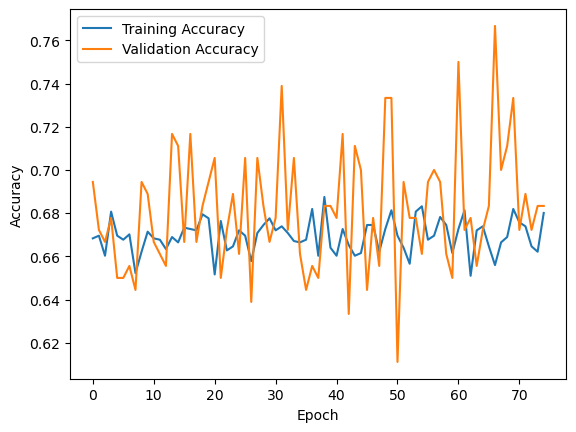

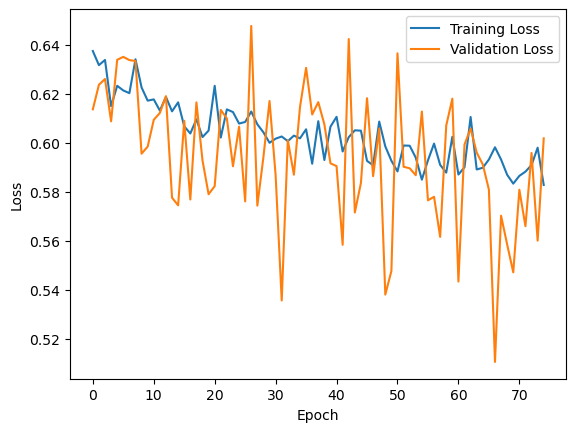

In [23]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
tf.Tensor([0.], shape=(1,), dtype=float32)
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
x shape: (1616, 27648)
label y: (1616, 1)


/Users/denisekittelmann/miniconda3/envs/BiMo_3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
x shape: (180, 27648)
label y: (180, 1)
0.7666666666666667


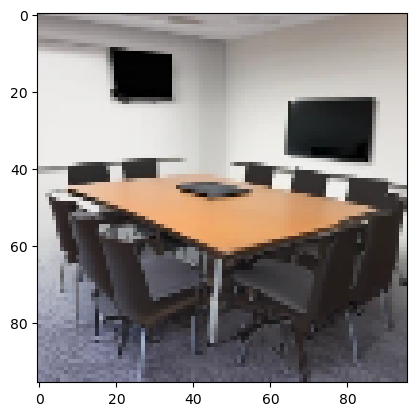

In [17]:
train_dataset = tf.data.Dataset.from_generator(
        lambda: generate_dataset(img_dir_lead, img_dir_trail, class_names_L, class_names_T, label_dict, image_size = (96,96), seed = seed),
        output_signature=(
            tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),  # shape of x 
            tf.TensorSpec(shape=(1), dtype=tf.float32)  # shape of y 
        )
    ) 

# .map(encoder_preproc).map(flatten)

for x,y in train_dataset.shuffle(99999).batch(32).map(img_preproc).take(1):   
    plt.imshow(x[0])
    print(y[0])
    
        
from sklearn.linear_model import LogisticRegression

for x, y in train_dataset.shuffle(99999).batch(5028).map(img_preproc).map(flatten).take(1):
    print("x shape:",x.shape)
    print("label y:", y.shape)

    clf = LogisticRegression(random_state=0).fit(x, y)
    print(clf.score(x, y))
    
for x, y in val_dataset.shuffle(99999).batch(5028).map(img_preproc).map(flatten).take(1):
    print("x shape:",x.shape)
    print("label y:", y.shape)

    #clf = LogisticRegression(random_state=0).fit(x, y)
    print(clf.score(x, y))

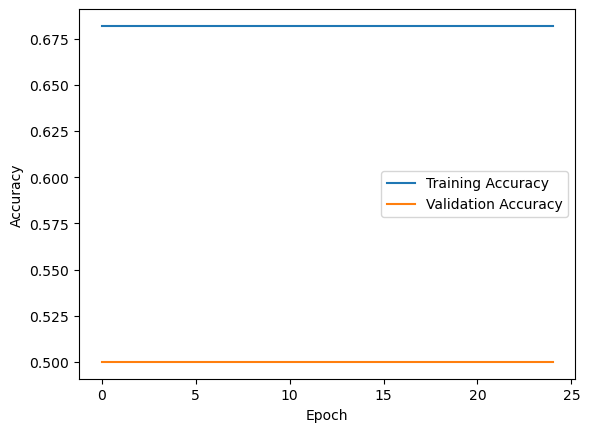

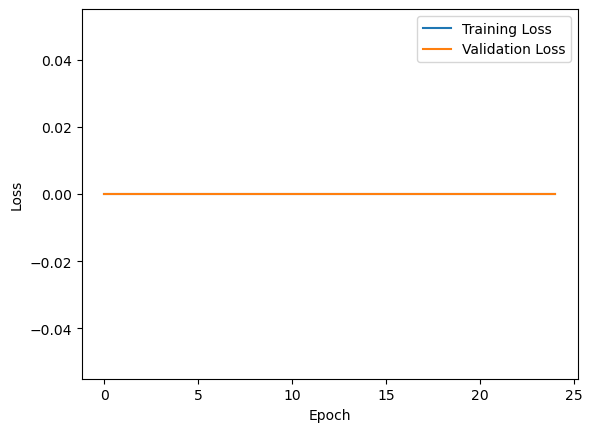

In [10]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

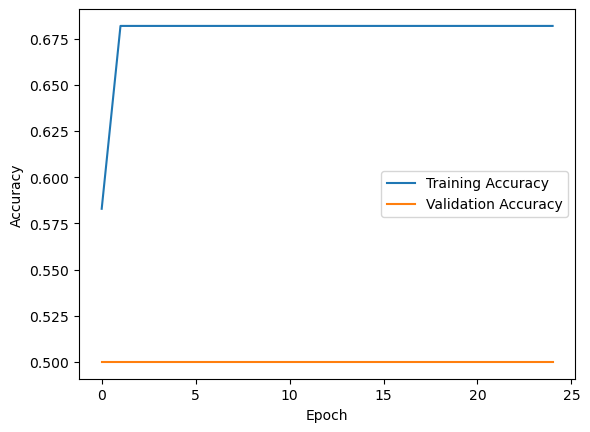

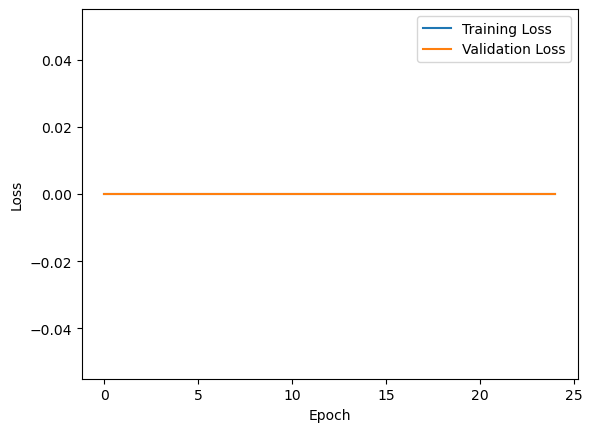

In [8]:
# experimental task 

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()